# Chapter 4:  Speech/voice Recognition 

# Use Case 1:  Voice Controlled Smart Light 

# Model: MobileNet V1 (CNN)

# Step 1: Data Collection (downloading)

# Step 2: Data/Image Exploration 

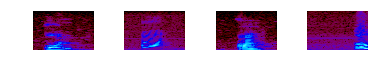

In [2]:
# Five classes (manhole, pavement, pothole, roadmarkings, shadow)
# Import the necessary modules

import cv2
import glob
import numpy as np
import os
import random
import matplotlib.pyplot as plt

# List to store the images of each class

images =[]


# This is to show plot 
%matplotlib inline

# Function to read image file one by one and append to the images list

def data_explorer(image_dir, images_to_explore):  
        
    image_files =os.path.join(image_dir, "*.jpg") 
    files = glob.glob (image_files) 
        
    for myFile in files:
        image = cv2.imread (myFile)
        images.append (image)

    data = np.array(images) 
    
 
 # random indexes for the images to be explored
 
    r =len(data)
    #print (r)
    my_randoms = random.sample(range(r), images_to_explore)
    # list of random indexes 
    data_toexplore = my_randoms

    # Plot the images to explore 

    for i in range(len(data_toexplore)):
        plt.subplot(1, 4, i+1)
        plt.axis('off')
        #print(i)
        plt.imshow(data[data_toexplore[i]])
        plt.subplots_adjust(wspace=0.5)

    plt.show()
    
DATASET_PATH = "dataset/on"  

#Call the function with 4 random images to be explored

data_explorer(DATASET_PATH, 4)
   

# Step 3: Pre-processing

# Step 4: Model Training and Validation

In [ ]:
Download the mobilenet_1.0_224 model from https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet_v1.
md, and save it into a dirctory that will be your model directory in the following code (we used Mobilenet)

In [7]:


import os
import argparse
import tensorflow as tf
from IPython.display import Image

import retrain  # Available in the usecase 2 folder

In [8]:
# Have a look at the default values
# For the meaning of these values look at retrain_CNN.py:

FLAGS = argparse.Namespace()
FLAGS.image_dir = ""
FLAGS.output_graph = '.\\retrained_graph.pb'
FLAGS.output_labels = '.\\output_labels.txt'
FLAGS.summaries_dir = '.\\summaries'
FLAGS.how_many_training_steps = 4000
FLAGS.learning_rate = 0.01
FLAGS.testing_percentage = 10
FLAGS.validation_percentage = 10
FLAGS.eval_step_interval = 10
FLAGS.train_batch_size = 100
FLAGS.test_batch_size = -1
FLAGS.validation_batch_size = 100
FLAGS.intermediate_store_frequency =10
FLAGS.print_misclassified_test_images = False
FLAGS.model_dir = "."
FLAGS.bottleneck_dir = "bottlenecks"
FLAGS.final_tensor_name = "final_result"
FLAGS.flip_left_right = False
FLAGS.random_crop = 0
FLAGS.random_scale = 0
FLAGS.random_brightness = 0
FLAGS.intermediate_output_graphs_dir ="."
FLAGS.architecture = "mobilenet_1.0_224" # for Incentive- inception_v3

In [11]:
# change default: 
FLAGS.how_many_training_steps = 1000
FLAGS.model_dir = "Mobilenet" # for Incentive make it inactive or show the path for the downloaded model
FLAGS.output_graph = "retrained_mobilenet_graph.pb"  
FLAGS.output_labels = "retrained_labels.txt"
FLAGS.image_dir = "dataset-original" # For the modified dataset use the modified dataset directory 


In [ ]:
retrain.FLAGS = FLAGS
tf.app.run(main=retrain.main)

# Step 5: Test model on new picture individual Acne Images in Raspberry Pi or Other Devices.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np
import tensorflow as tf
# Function to load a pretrained model (transfer learning)

def load_graph(model_file):
  graph = tf.Graph()
  graph_def = tf.GraphDef()

  with open(model_file, "rb") as f:
    graph_def.ParseFromString(f.read())
  with graph.as_default():
    tf.import_graph_def(graph_def)

  return graph

# Function for image to tensor conversion

def read_tensor_from_image_file(file_name,
                                input_height=299,
                                input_width=299,
                                input_mean=0,
                                input_std=255):
  input_name = "file_reader"
  #output_name = "normalized"
  file_reader = tf.read_file(file_name, input_name)
  if file_name.endswith(".png"):
    image_reader = tf.image.decode_png(
        file_reader, channels=3, name="png_reader")
  elif file_name.endswith(".gif"):
    image_reader = tf.squeeze(
        tf.image.decode_gif(file_reader, name="gif_reader"))
  elif file_name.endswith(".bmp"):
    image_reader = tf.image.decode_bmp(file_reader, name="bmp_reader")
  else:
    image_reader = tf.image.decode_jpeg(
        file_reader, channels=3, name="jpeg_reader")
  float_caster = tf.cast(image_reader, tf.float32)
  dims_expander = tf.expand_dims(float_caster, 0)
  resized = tf.image.resize_bilinear(dims_expander, [input_height, input_width])
  normalized = tf.divide(tf.subtract(resized, [input_mean]), [input_std])
  sess = tf.Session()
  result = sess.run(normalized)

  return result

# Function for loading label files

def load_labels(label_file):
  label = []
  proto_as_ascii_lines = tf.gfile.GFile(label_file).readlines()
  for l in proto_as_ascii_lines:
    label.append(l.rstrip())
  return label


In [2]:
# Provide input to be predicted with model file and label or class file 
file_name = "test_images/on2.jpg"
model_file = "retrained_mobilenet_graph.pb"
label_file = "retrained_labels.txt"

# Fixed input for Mobilenet V1
input_height = 224
input_width = 224
input_mean = 0
input_std = 255
input_layer = "input"
output_layer = "final_result"

# Load the model
graph = load_graph(model_file)
t = read_tensor_from_image_file(
      file_name,
      input_height=input_height,
      input_width=input_width,
      input_mean=input_mean,
      input_std=input_std)

input_name = "import/" + input_layer
output_name = "import/" + output_layer
input_operation = graph.get_operation_by_name(input_name)
output_operation = graph.get_operation_by_name(output_name)

with tf.Session(graph=graph) as sess:
    results = sess.run(output_operation.outputs[0], {
        input_operation.outputs[0]: t
    })

results = np.squeeze(results)

top_k = results.argsort()[-5:][::-1]
labels = load_labels(label_file)
for i in top_k:
    print("Pontenially", labels[i], "with confidence level",results[i])

Pontenially on with confidence level 0.5684126
Pontenially off with confidence level 0.17668194
Pontenially no with confidence level 0.1430924
Pontenially yes with confidence level 0.09432695
Pontenially stop with confidence level 0.017486034
